# Taxi Demand Prediction
Using Cross-Validation to Select the Best Model

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


In [11]:

# Load data
df = pd.read_csv("data/joined_data.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Group by date and type
grouped_data = df.groupby(['Date', 'Type']).size().reset_index(name='cab_count')
pivot_df = grouped_data.pivot(index='Date', columns='Type', values='cab_count').fillna(0).reset_index()

# Feature engineering
pivot_df['day_of_week'] = pivot_df['Date'].dt.dayofweek
pivot_df['month'] = pivot_df['Date'].dt.month
pivot_df['day'] = pivot_df['Date'].dt.day

# Define features and target
features = ['Ride Share', 'day_of_week', 'month', 'day']
target = 'Taxi'
X = pivot_df[features]
y = pivot_df[target]


C:\Users\Andy\AppData\Local\Temp\ipykernel_25044\3311990536.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/joined_data.csv")


In [12]:

# CV for traditional models
lr_cv = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42), X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv = cross_val_score(GradientBoostingRegressor(n_estimators=100, random_state=42), X, y, cv=5, scoring='neg_mean_squared_error')

lr_cv_rmse = np.sqrt(-lr_cv.mean())
rf_cv_rmse = np.sqrt(-rf_cv.mean())
xgb_cv_rmse = np.sqrt(-xgb_cv.mean())


In [13]:

print("Neural Network Cross-Validation:")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kf = KFold(n_splits=5, shuffle=False)
nn_rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.values[train_idx], y.values[val_idx]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_fold.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
              epochs=100, batch_size=8, callbacks=[early_stop], verbose=0)

    preds = model.predict(X_val_fold).flatten()
    rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    nn_rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.2f}")

mean_nn_rmse = np.mean(nn_rmse_scores)


Neural Network Cross-Validation:


D:\Projects\github.com\andy277\project_part4\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 1 RMSE: 297.55


D:\Projects\github.com\andy277\project_part4\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 2 RMSE: 390.42


D:\Projects\github.com\andy277\project_part4\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 3 RMSE: 375.97


D:\Projects\github.com\andy277\project_part4\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 4 RMSE: 388.68


D:\Projects\github.com\andy277\project_part4\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 5 RMSE: 413.67


In [14]:

# Compare all models
all_models = [
    ("Linear Regression", lr_cv_rmse),
    ("Random Forest", rf_cv_rmse),
    ("XGBoost", xgb_cv_rmse),
    ("Neural Network", mean_nn_rmse)
]

# Show all RMSE values for comparison
print("Cross-Validated RMSE (5-fold):")
print(f"Linear Regression: {lr_cv_rmse:.2f}")
print(f"Random Forest: {rf_cv_rmse:.2f}")
print(f"XGBoost: {xgb_cv_rmse:.2f}")
print(f"Neural Network: {mean_nn_rmse:.2f}")

best_model_name, best_model_rmse = min(all_models, key=lambda x: x[1])
print(f"Best Model: {best_model_name} (RMSE = {best_model_rmse:.2f})")


Cross-Validated RMSE (5-fold):
Linear Regression: 434.38
Random Forest: 425.55
XGBoost: 400.96
Neural Network: 373.26
Best Model: Neural Network (RMSE = 373.26)


In [15]:

# Final train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

if best_model_name == "Neural Network":
    final_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    final_model.compile(optimizer='adam', loss='mse')
    final_model.fit(X_train_scaled, y_train, validation_split=0.2,
                    epochs=100, batch_size=8, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=0)
    final_preds = final_model.predict(X_test_scaled).flatten()
else:
    model_map = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    final_model = model_map[best_model_name]
    final_model.fit(X_train, y_train)
    final_preds = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, final_preds))
r2 = r2_score(y_test, final_preds)
print(f"Final Model Evaluation: RMSE = {rmse:.2f}, R2 = {r2:.2f}")


D:\Projects\github.com\andy277\project_part4\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Final Model Evaluation: RMSE = 540.19, R2 = -1.23


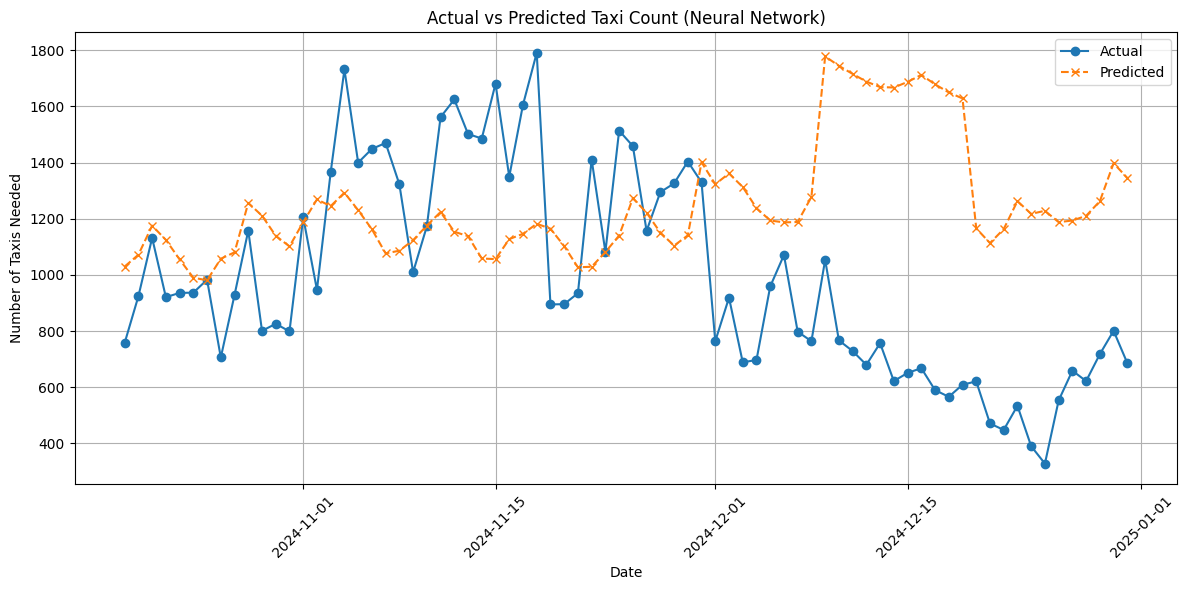

In [16]:

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(pivot_df['Date'].iloc[-len(y_test):], y_test.values, label='Actual', marker='o')
plt.plot(pivot_df['Date'].iloc[-len(y_test):], final_preds, label='Predicted', linestyle='--', marker='x')
plt.title(f"Actual vs Predicted Taxi Count ({best_model_name})")
plt.xlabel("Date")
plt.ylabel("Number of Taxis Needed")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
